# 2. Motivating examples 

In this notebook, we provide the code required to produce figure 1, 2 and 3. The second and third figure require the use of a parallel environment called Numba. The simulations are typically long and time consuming, so the user is advised to either run simulations with a smaller number of samples, or simply use the data used for the paper which are available in this folder.  


In [1]:
# Numba is a parralel environment that allows to easily run parallel loops
# It is compatible with numpy, it can be tricky to install
# Try: !pip install numba
# Or follow : https://numba.readthedocs.io/en/stable/user/installing.html
# If you have the error "initialization of _internal failed without raising an exception"
# It probably means that you need to restart the kernel and install an older version of numpy
# follow the steps below
# restart kernel
# !pip install numpy==1.23.5
# !pip install -U numba

In [2]:
#
# !!! MODIFY CODE HERE
#
run_own_code=True #Set this to true of you wish to generate your own results
my_number_of_sample=10000 #the number of sample used for the paper simulation is 100000, but this will be very long. 

In [3]:
# Import packages and set color schemes
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

myblue = (0,119/235,187/235)
myred=(187/235,85/235,102/235)
myyellow=(221/235,170/235,51/235)
mygrey=(187/235,187/235,187/235)
mygreen="#66BB55"
mymagenta="#7733DD"
myblack="#48494B"

font_size = 25
line_w=3

# Figure 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


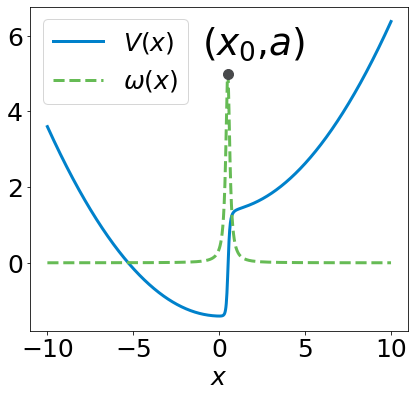

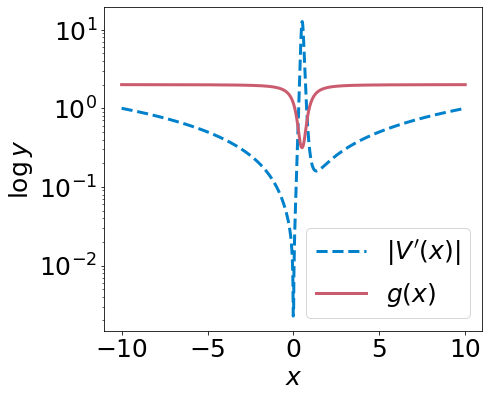

In [4]:
### Parameters of the modified harmonic potential
b=0.1
a=5
x0=.5
c=0.1
m3=0.1
M3=2

# Code the potential defined in (2.2)
def U(x):
    res = (a**1.5*b**0.5*x0*np.arctan((a/b)**0.5*(x-x0))+(a*b*(a*x0*(x-x0)-b))/(a*(x-x0)**2+b)+c*(x-x0)**2+2*c*(x-x0)*x0)*0.5
    return res
# Code the function defined in (2.1)
def omega(x):
    wx =b/(b/a+(x-x0)**2)
    return wx
# Code the function defined in (2.1)
def Up(x):
    wx =b/(b/a+(x-x0)**2)
    res = (wx*wx+c)*x
    return res
# Code the monitor function defined in Figure 5.
def getg3(x): 
    wx =(b/a+(x-x0)**2)/b
    f = wx*wx
    xi = f+m3
    g = 1/(1/M3+1/np.sqrt(xi))
    return g
import matplotlib.ticker as mtick
plt.rc('xtick', labelsize=font_size) 
plt.rc('ytick', labelsize=font_size) 

########################################
fig, (axs)= plt.subplots(1, 1,figsize=(7,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.15,
                        bottom=0.15, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
s=np.linspace(-10,10,1000)
axs.plot(s,U(s),label="$V(x)$",linewidth=line_w,color=myblue)
axs.plot(s,omega(s),"--",label="$\\omega(x)$",linewidth=line_w,color=mygreen)
axs.plot(s[np.argmax(omega(s))],np.max(omega(s)),"o",markersize=10,color=myblack)
axs.annotate('($x_0$,$a$)', xy=(s[np.argmax(omega(s))],np.max(omega(s))),fontsize=font_size*1.5, textcoords='data',xytext=(-1,a+0.5)) # <--
axs.legend(loc = "upper left",fontsize=font_size)
# axs.set_ylabel("$y$",fontsize=font_size)
axs.set_xlabel("$x$",fontsize=font_size)

plt.savefig('figures/spring_potential_left.eps', format='eps')
plt.savefig('figures/spring_potential_left.pdf', format='pdf')

fig, (axs)= plt.subplots(1, 1,figsize=(7,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.15,
                        bottom=0.15, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
axs.semilogy(s,np.abs(Up(s)),"--",label="$|V'(x)|$",linewidth=line_w,color=myblue)
axs.semilogy(s,np.abs(getg3(s)),color=myred,linewidth=line_w,label="$g(x)$")
axs.legend(loc = "lower right",fontsize=font_size)
axs.set_xlabel("$x$",fontsize=font_size)
axs.set_ylabel("$\\log y$",fontsize=font_size)

plt.savefig('figures/spring_potential_right.eps', format='eps')
plt.savefig('figures/spring_potential_right.pdf', format='pdf')

# Figure 2

To produce Figure 2, we implement the numerical methods with the modified harmonique potential using the direct time-rescaled scheme (2.10) and the original overdamped scheme (2.9). To improve performance, we use Numba, an parallel environment package. 

In [5]:
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import numpy as np
import pandas as pd


## Define the potential and the monitor function

In [6]:
# Parameters for the monitor function 
######################################
M=2
m=0.001
b=0.1
a=10
x0=0.5
c=0.1

def U(x):
    """
    Compute the value of the potential (2.2) at position x.
    Input
    -----
    x: float 
        value of the position
    Return
    ------
    res: float
        value of the potential at position x.
    """
    res = (a**1.5*b**0.5*x0*np.arctan((a/b)**0.5*(x-x0))+(a*b*(a*x0*(x-x0)-b))/(a*(x-x0)**2+b)+c*(x-x0)**2+2*c*(x-x0)*x0)*0.5
    return res

@njit(float64(float64))
def Up(x):
    """
    Compute the value of the derivative of the potential (2.1) at position x.
    Input
    -----
    x: float 
        value of the position
    Return
    ------
    res: float
        value of the potential derivative at position x.
    """
    wx =b/(b/a+(x-x0)**2)
    res = (wx*wx+c)*x
    return res

## Using the different defintion of the function
@njit(float64(float64))
def getg(x): 
    """
    Compute the value of the monitor function at position x.
    Input
    -----
    x: float 
        value of the position
    Return
    ------
    res: float
        value of the monitor function at position x.
    """
    wx =(b/a+(x-x0)**2)/b
    f = wx*wx
    xi = f+m
    g = 1/(1/M+1/np.sqrt(xi))
    return g

@njit(float64(float64))
def getgprime(x):
    """
    Compute the value of the derivative of monitor function at position x.
    Input
    -----
    x: float 
        value of the position
    Return
    ------
    res: float
        value of the derivative of monitor function at position x.
    """
    wx =(b/a+(x-x0)**2)/b
    f = wx*wx
    fp = 4*(x-x0)*((b/a)+(x-x0)**2)/b**2
    xi=np.sqrt(f+m*m)
    gprime= M**2*fp/(2*xi*(xi+M)**2)
    return gprime


## Define useful functions to read the datasets produced by the numerical methods

In [7]:
def dta_format_over(mat):
    """
    Create a dataset to save easily and quickly in pickle format
    Input
    -----
    A (M,) dataset produced by the functions sample_noada(...) or sample_re(...)
    Return
    ------
    dta: Panda dataframe
    A Matrix with appropriate title for each columns: 
        - sim: the simulation number (out of the M samples)
        - count: the number of step required to reach the time T
        - t : the time reached (for the direct rescaled, this will vary)
        - x : the value of the samples at time t, after count steps for the sim simulations
        - g: value of the monitor function 
        - gp: value of the derivative of the monitor function 
    """
    dta = pd.DataFrame(mat,columns=["sim","count","t","x","g","gp"])
    return dta

## Define the numerical methods: first implementation of the original Langevin dynamics (2.9)

In [8]:
####################
#  Numerical method#
####################  

@njit(float64[:](float64,int32,float64,float64))
def one_traj_noada(x,Nt,dt,tau):
    """
    Run the simulation for one sample path
    Input
    -----
    Ntot: int
        Number of counts to take to get to Tf with dt
    dt: float 
        Value of time increment. Is 1/N.
    tau: float 
        Is in the multiplicative term of the SDE in sqrt(2 \tau dt). 
    Return
    ------
    x: float
        Value of X(T) as approximated by the numerical scheme chosen
    """

    t = 0
    count=0
    # set up vectors to save results
    ctxg_list = np.zeros(5)

    for count in range(Nt):
        # Compute the values of f, g, g' and g*dt 
        #########################################
        f = -Up(x)

        # No adaptivity   
        ###############
        t+=dt

        # Compute the values of next count 
        #################################
        b1 = np.random.normal(0,1)
        x+=f*dt+np.sqrt(tau*dt*2)*b1

    #****************************
    #* Save (x) and update time *
    #****************************
    ctxg_list[0]=count
    ctxg_list[1]=t
    ctxg_list[2]=x
    ctxg_list[3]= 1 #value of g not used =1
    ctxg_list[4]= 0 #value of g' not used = 0 
    
    return (ctxg_list)

####################################################
#  Numerical method ran over M statistical samples #
####################################################

@njit(parallel=True)
def sample_noada(x,n_samples,Nt,dt,tau): # Function is compiled and runs in machine code

    """
    Input
    -------
    x : float   
        initial value
    n_samples: int
        Number of sample to draw
    Nt: int 
        number of run
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)

    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the SDE at time T
    
    """
    #set up the matrix to save the results 
    simctxdt_list=np.zeros((n_samples,6))
    for j in range(n_samples):
        ctxg_list =one_traj_noada(x,Nt,dt,tau)
        simctxdt_list[j,1:6]=ctxg_list
        simctxdt_list[j,0]=j
    return simctxdt_list


## Define the numerical methods: secondly implementation of the direct time-rescaled Langevin dynamics (2.10)

In [9]:
####################
#  Numerical method#
####################  

@njit(float64[:](float64,int32,float64,float64))
def one_traj_re(x,Nt,dt,tau):
    """
    Run the simulation for one sample path
    Input
    -----
    Ntot: int
        Number of counts to take to get to Tf with dt
    dt: float 
        Value of time increment. Is 1/N.
    tau: float 
        Is in the multiplicative term of the SDE in sqrt(2 \tau dt). 
    Return
    ------
    x: float
        Value of X(T) as approximated by the numerical scheme chosen
    """

    t = 0
    count=0
    # set up vectors to save results
    ctxg_list = np.zeros(5)

    for count in range(Nt):
        # Compute the values of f, g, g' and g*dt 
        #########################################
        f = -Up(x)


        # EM applied to non transformed SDE but rescale counts
        #####################################################
        g=getg(x)
        gp=0 #do not want to add this term so set it to 0. 
        gdt=g*dt
        t+=gdt


        # Compute the values of next count 
        #################################
        b1 = np.random.normal(0,1)
        x+=f*gdt+np.sqrt(tau*gdt*2)*b1+dt*tau*gp

    #****************************
    #* Save (x) and update time *
    #****************************
    ctxg_list[0]=count
    ctxg_list[1]=t
    ctxg_list[2]=x
    ctxg_list[3]=g #value of g not used =1
    ctxg_list[4]=gp #value of g' not used = 0 
    
    return (ctxg_list)

####################################################
#  Numerical method ran over M statistical samples #
####################################################

@njit(parallel=True)
def sample_re(x,n_samples,Nt,dt,tau): # Function is compiled and runs in machine code

    """
    Compute samples using the direct time-rescaled timestepping scheme (2.10)
        \tilde{X}_{n+1} =
        \tilde{X}_n - \nabla V(\tilde{X}_n) g(\tilde{X}_n) h +
        \sqrt{2 \beta^{-1} g(\tilde{X}_n)h} \Delta \W_n. 

    Input
    -------
    x : float   
        initial value
    n_samples: int
        Number of sample to draw
    Nt: int 
        number of run
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)

    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the SDE at time T
    
    """
    #set up the matrix to save the results 
    simctxdt_list=np.zeros((n_samples,6))
    for j in range(n_samples):
        ctxg_list =one_traj_re(x,Nt,dt,tau)
        simctxdt_list[j,1:6]=ctxg_list
        simctxdt_list[j,0]=j
    return simctxdt_list


In [10]:
# ##################
# ## Test function #
# ##################
x=1
n_samples=100
Nt=100
dt=0.01
tau=1
sample_re(x,n_samples,Nt,dt,tau)
sample_noada(x,n_samples,Nt,dt,tau)


array([[ 0.00000000e+00,  9.90000000e+01,  1.00000000e+00,
        -6.36175413e-01,  1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  9.90000000e+01,  1.00000000e+00,
        -1.06441594e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.00000000e+00,  9.90000000e+01,  1.00000000e+00,
        -6.17521341e-01,  1.00000000e+00,  0.00000000e+00],
       [ 3.00000000e+00,  9.90000000e+01,  1.00000000e+00,
         1.63530304e+00,  1.00000000e+00,  0.00000000e+00],
       [ 4.00000000e+00,  9.90000000e+01,  1.00000000e+00,
        -2.82764650e-01,  1.00000000e+00,  0.00000000e+00],
       [ 5.00000000e+00,  9.90000000e+01,  1.00000000e+00,
         2.43062850e-01,  1.00000000e+00,  0.00000000e+00],
       [ 6.00000000e+00,  9.90000000e+01,  1.00000000e+00,
        -5.61798032e-01,  1.00000000e+00,  0.00000000e+00],
       [ 7.00000000e+00,  9.90000000e+01,  1.00000000e+00,
        -1.10427796e+00,  1.00000000e+00,  0.00000000e+00],
       [ 8.00000000e+00,  9.90000000e+01,  1.000

## Run the method
Running the numerical methods for the scheme (2.9) and (2.10) is very time-consuming if we use the required number of samples (n_sample=10^5), you can reduce the number of samples or simply use the provided dataset to plot the results. The cell below saves your results in the folder "data", so you can load them easily without having to run the code again. 

In [11]:
if run_own_code==True:
    # Parameters to obtain the sample yielded in Figure 2
    pot="spring"
    tau=0.1
    n_samples=my_number_of_sample
    h=0.001
    T=50
    Nt=int(T*1/h)+1
    ########################################################################
    ##### Obtain data to plot with the spring problem and save the values ##
    ########################################################################
    dta_re = dta_format_over(sample_re(x,n_samples,Nt,h,tau))
    dta_noada = dta_format_over(sample_noada(x,n_samples,Nt,h,tau))
    list_param = str(pot)+'-tau='+str(tau)+'-M='+str(M)+'m='+str(m)+"-Nt="+str(Nt)+"-ns="+str(n_samples)+"-h="+str(h)
    dta_noada.to_pickle("./CFiles/data/histograms/dta_noada_"+list_param)
    dta_re.to_pickle("./CFiles/data/histograms/dta_re_"+list_param)

In [12]:
dta_noada.head()

,sim,count,t,x,g,gp
0,0.0,50000.0,50.001,-0.817573,1.0,0.0
1,1.0,50000.0,50.001,0.153871,1.0,0.0
2,2.0,50000.0,50.001,-0.698326,1.0,0.0
3,3.0,50000.0,50.001,-0.030142,1.0,0.0
4,4.0,50000.0,50.001,-1.011499,1.0,0.0


## Or simply load pre run data
Because it is time-consuming to obtain the appropriate number of samples, I saved the data used for the figures in the paper in the folder "data_prerun". Do not run the following cell if you prefer to plot the data you generated yourself. 

In [13]:
#################################################
##### Load the saved values in the pickle file ##
##### If you don't want to wait too long       ##
#################################################
if run_own_code==False:
    pot="spring"
    tau=0.1
    n_samples=100000
    h=0.001
    T=50
    Nt=int(T*1/h)+1
    list_param = str(pot)+'-tau='+str(tau)+'-M='+str(M)+'m='+str(m)+"-Nt="+str(Nt)+"-ns="+str(n_samples)
    dta_noada=pd.read_pickle("./data_prerun/histograms/dta_noada_"+list_param)
    dta_re=pd.read_pickle("./data_prerun/histograms/dta_re_"+list_param)


## Finally plot the figures

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


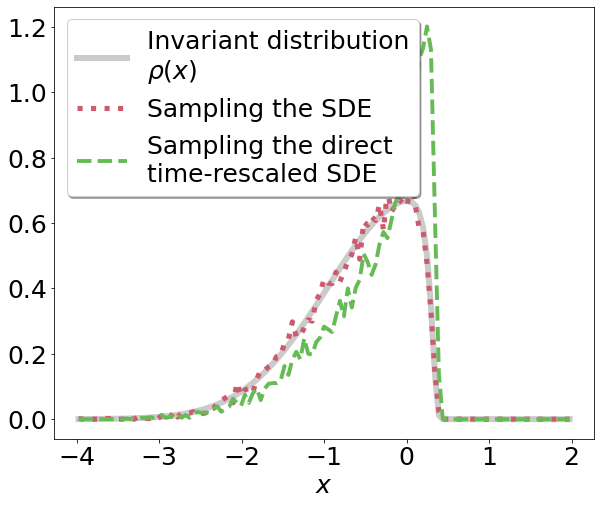

In [14]:
# Get the last steps in the code 
counti = dta_noada['count'].max()
# Get only the samples at the final step T
dta_noada_i=dta_noada[dta_noada['count']==counti]
dta_re_i=dta_re[dta_re['count']==counti]

## Obtain histograms
range_bins=[-4,2]
nbins=125

# SDE
histogram_sde,bins = np.histogram(dta_noada_i["x"],bins=nbins,range=range_bins, density=True)
midx_sde = (bins[0:-1]+bins[1:])/2

# Invariant distribution
rho = np.exp(- U(midx_sde)/tau)
rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

# Rescaled
histogram_re,bins = np.histogram(dta_re_i["x"],bins=nbins,range=range_bins, density=True)
midx_re = (bins[0:-1]+bins[1:])/2

## Set up the plots 
fig, (axs)= plt.subplots(1, 1,figsize=(10,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.15,
                        bottom=0.15, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)


# Plots 
# Plots 
axs.plot(midx_sde,rho,linewidth=line_w*2,label='Invariant distribution\n$\\rho(x)$',color=mygrey)
axs.plot(midx_sde,histogram_sde,":",linewidth=line_w*1.7,label='Sampling the SDE',color=myred)
axs.plot(midx_re,histogram_re,"--",linewidth=line_w*1.3,label='Sampling the direct\ntime-rescaled SDE',color=mygreen)

# Legend 
axs.legend(loc='upper left',fancybox=True,shadow=True,fontsize=font_size)
axs.set_xlabel("$x$",fontsize=font_size)
plt.savefig('figures/Naivetimerescaledplot.eps', format='eps')
plt.savefig('figures/Naivetimerescaledplot.pdf', format='pdf')


# Figure 3

For figure 3, we need to add the numerical scheme for the IP-transformed SDE (2.14). 

## Define the numerical methods: implementation of the IP-transformed Langevin dynamics (2.14)

In [15]:

####################
#  Numerical method#
####################  

@njit(float64[:](float64,int32,float64,float64))
def one_traj_tr(x,Nt,dt,tau):
    """
    Run the simulation for one sample path
    Input
    -----
    Ntot: int
        Number of counts to take to get to Tf with dt
    dt: float 
        Value of time increment. Is 1/N.
    tau: float 
        Is in the multiplicative term of the SDE in sqrt(2 \tau dt). 
    Return
    ------
    x: float
        Value of X(T) as approximated by the numerical scheme chosen
    """

    t = 0
    count=0
    # set up vectors to save results
    ctxg_list = np.zeros(5)

    for count in range(Nt):
        # Compute the values of f, g, g' and g*dt 
        #########################################
        f = -Up(x)

        # EM applied to transformed SDE and counts using t+=dt  
        #####################################################
        g=getg(x)
        gp=getgprime(x)
        gdt=g*dt
        t+=dt



        # Compute the values of next count 
        #################################
        b1 = np.random.normal(0,1)
        x+=f*gdt+np.sqrt(tau*gdt*2)*b1+dt*tau*gp

    #****************************
    #* Save (x) and update time *
    #****************************
    ctxg_list[0]=count
    ctxg_list[1]=t
    ctxg_list[2]=x
    ctxg_list[3]= g #value of g not used =1
    ctxg_list[4]= gp #value of g' not used = 0 
    
    return (ctxg_list)

####################################################
#  Numerical method ran over M statistical samples #
####################################################

@njit(parallel=True)
def sample_tr(x,n_samples,Nt,dt,tau): # Function is compiled and runs in machine code

    """
    Input
    -------
    x : float   
        initial value
    n_samples: int
        Number of sample to draw
    Nt: int 
        number of run
    dt: float
        Size of the time discretization 
    tau: float
        Value of the temperature of the DW SDE (+ sqrt(2*tau)*dW)
    Return
    -------
    y_final: np.array
        Array of shape (M,). Sample of numerical approximation of the DW SDE at time T
    
    """
    #set up the matrix to save the results 
    simctxdt_list=np.zeros((n_samples,6))
    for j in range(n_samples):
        ctxg_list =one_traj_tr(x,Nt,dt,tau)
        simctxdt_list[j,1:6]=ctxg_list
        simctxdt_list[j,0]=j
    return simctxdt_list


In [16]:
# ##################
# ## Test function #
# ##################
x=1
n_samples=100
Nt=100
dt=0.01
tau=1


## Run the method
Similarly, as before, running the numerical methods for the scheme (2.9) and (2.14) is very time consuming if we use the appropriate number of samples ($n_sample=10^5$), you can reduce the number of samples or simply use load the provided dataset to plot the results. The cell below saves your results in the folder "data", so you can load them easily without having to run the code again. 

### Small stepsize


In [17]:
if run_own_code==True:
    # Parameters to obtain the sample yielded in Figure 3
    pot="spring"
    tau=0.1
    n_samples=my_number_of_sample #the number of sample used for the paper simulation is 100000
    h=0.001
    T=50
    Nt=int(T*1/h)+1

    ########################################################################
    ##### Obtain data to plot with the spring problem and save the values ##
    ########################################################################
    dta_tr = dta_format_over(sample_tr(x,n_samples,Nt,h,tau))
    list_param = str(pot)+'-tau='+str(tau)+'-M='+str(M)+'m='+str(m)+"-Nt="+str(Nt)+"-ns="+str(n_samples)+"-h="+str(h)
    dta_noada.to_pickle("./CFiles/data/histograms/dta_noada_"+list_param)
    dta_tr.to_pickle("./CFiles/data/histograms/dta_re_"+list_param)

In [18]:
#################################################
##### Load the saved values in the pickle file ##
##### If you don't want to wait too long       ##
#################################################
# Small h parameter 
if run_own_code==False:
    x=0
    pot="spring"
    tau=0.1
    n_samples=100000
    h=0.001
    T=50
    Nt=int(T*1/h)+1
    list_param = str(pot)+'-tau='+str(tau)+'-M='+str(M)+'m='+str(m)+"-Nt="+str(Nt)+"-ns="+str(n_samples)
    dta_noada=pd.read_pickle("./data_prerun/histograms/dta_noada_"+list_param)
    dta_tr=pd.read_pickle("./data_prerun/histograms/dta_tr_"+list_param)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


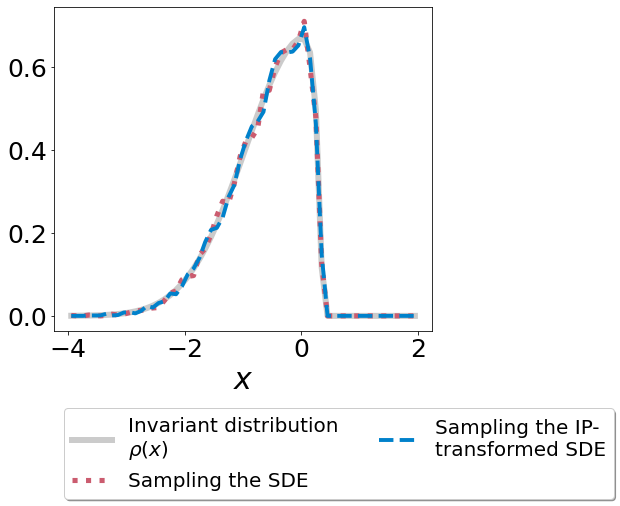

In [19]:
line_w=3
font_size=20
## Set up the plots 
fig, (axs)= plt.subplots(1, 1,figsize=(7,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.15,
                        bottom=0.15, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
######################### SMALL H ###########################
#############################################################
nbins=60
range_int=[-5,4]

# List of time
counti = dta_noada['count'].max()
# * Dataframe using hessian
df_noada_i=dta_noada[dta_noada['count']==counti]
# * Dataframe using first derivative 
df_tr_i=dta_tr[dta_tr['count']==counti]



# SDE
histogram_sde,bins = np.histogram(df_noada_i["x"],bins=nbins,range=range_bins, density=True)
midx_sde = (bins[0:-1]+bins[1:])/2

# Invariant distribution
rho = np.exp(- U(midx_sde)/tau)
rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

# Transformed
histogram_tr,bins = np.histogram(df_tr_i["x"],bins=nbins,range=range_bins, density=True)
midx_tr = (bins[0:-1]+bins[1:])/2

# Plots 
axs.plot(midx_sde,rho,linewidth=line_w*2,label='Invariant distribution\n$\\rho(x)$',color=mygrey)
axs.plot(midx_sde,histogram_sde,":",linewidth=line_w*1.7,label='Sampling the SDE',color=myred)
axs.plot(midx_tr,histogram_tr,"--",linewidth=line_w*1.3,label='Sampling the IP-\ntransformed SDE',color=myblue)
axs.set_xlabel("$x$",fontsize=30)
axs.legend(loc='lower left',fancybox=True,shadow=True,ncol=2,fontsize=font_size,bbox_to_anchor=(0., -0.55))
plt.savefig('./figures/spring_transformed.eps', format='eps')
plt.savefig('./figures/spring_transformed.pdf', format='pdf')



### Large stepsize


In [20]:
# Parameters to obtain the sample yielded in Figure 3
if run_own_code==True:
    pot="spring"
    tau=0.1
    n_samples=my_number_of_sample #100000
    h=0.05
    T=70
    Nt=int(T*1/h)+1

    ########################################################################
    ##### Obtain data to plot with the spring problem and save the values ##
    ########################################################################
    df_tr_largeh = dta_format_over(sample_tr(x,n_samples,Nt,h,tau))
    df_noada_largeh = dta_format_over(sample_noada(x,n_samples,Nt,h,tau))

    list_param = str(pot)+'-tau='+str(tau)+'-M='+str(M)+'m='+str(m)+"-Nt="+str(Nt)+"-ns="+str(n_samples)+"-h="+str(h)
    df_tr_largeh.to_pickle("./CFiles/data/histograms/dta_tr_"+list_param)
    df_noada_largeh.to_pickle("./CFiles/data/histograms/dta_noada_"+list_param)


In [21]:
#################################################
##### Load the saved values in the pickle file ##
##### If you don't want to wait too long       ##
#################################################
# Large h parameter 
if run_own_code==False:
    x=0
    pot="spring"
    tau=0.1
    n_samples=100000
    h=0.001
    T=50
    Nt=int(T*1/h)+1
    list_param = str(pot)+'-tau='+str(tau)+'-M='+str(M)+'m='+str(m)+"-Nt="+str(Nt)+"-ns="+str(n_samples)
    df_noada_largeh=pd.read_pickle("./data_prerun/histograms/dta_noada_"+list_param)
    df_tr_largeh=pd.read_pickle("./data_prerun/histograms/dta_tr_"+list_param)

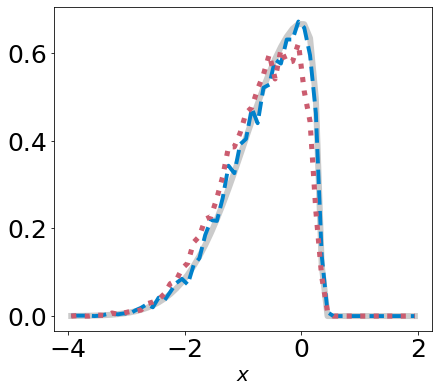

In [22]:
######################### LARGE H ###########################
#############################################################
fig, (axs)= plt.subplots(1, 1,figsize=(7,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.15,
                        bottom=0.15, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
# List of time
counti = df_noada_largeh['count'].max()
# * Dataframe using hessian
df_noada_i=df_noada_largeh[df_noada_largeh['count']==counti]
# * Dataframe using first derivative 
df_tr_i=df_tr_largeh[df_tr_largeh['count']==counti]

# SDE
histogram_sde,bins = np.histogram(df_noada_i["x"],bins=nbins,range=range_bins, density=True)
midx_sde = (bins[0:-1]+bins[1:])/2

# Invariant distribution
rho = np.exp(- U(midx_sde)/tau)
rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

# Transformed
histogram_tr,bins = np.histogram(df_tr_i["x"],bins=nbins,range=range_bins, density=True)
midx_tr = (bins[0:-1]+bins[1:])/2


# Plots 
axs.plot(midx_sde,rho,linewidth=line_w*2,label='Invariant distribution\n$\\rho_\infty(x)$',color=mygrey)
axs.plot(midx_tr,histogram_tr,"--",linewidth=line_w*1.3,label='Sampling the\ntransformed SDE',color=myblue)
axs.plot(midx_sde,histogram_sde,":",linewidth=line_w*1.7,label='Sampling the SDE',color=myred)

# Legend 
# axs.legend(loc='upper left',bbox_to_anchor=(-1.4, 1.225),ncols=3,fancybox=True,shadow=True,fontsize=font_size*0.9)
axs.set_xlabel("$x$",fontsize=font_size)
plt.savefig('figures/spring_transformed_largeh.eps', format='eps')
plt.savefig('figures/spring_transformed_largeh.pdf', format='pdf')